<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/Models_v2/Conv_VAE_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
import pandas as pd
from sklearn.metrics import roc_curve
tf.autograph.set_verbosity(0)
from google.colab import drive
drive.mount('/content/drive/')

TensorFlow 2.x selected.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


#### Import Data and plot it

In [0]:
def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

#plot_images(x_train, y_train, [0,10])

#### Select data, pre-process it and create dataset

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    #images[images >= 0.5] = 1.0
    #images[images < 0.5] = 0.0
    return images

def make_categorical(y):
    y_cat = tf.keras.utils.to_categorical(y)
    return y_cat

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
  x_train, y_train = pick_class(x_train, y_train, chosen_classes)
  x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
  x_train = cut_data(x_train, data_number)
  y_train = cut_data(y_train, data_number)

  train_images = set_pixels_binary(x_train)
  test_images = set_pixels_binary(x_test)

  train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
  test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

  batch_size = 100
  train_dataset = tf.data.Dataset.from_tensor_slices((train_images)).shuffle(len(y_train)).batch(batch_size)
  test_dataset = tf.data.Dataset.from_tensor_slices((test_images)).shuffle(len(y_test)).batch(batch_size)
  return x_train, y_train, x_test, y_test, train_dataset, test_dataset

#### Create Variational Autoencoder (VAE) Model

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.encoder_nn = tf.keras.models.Sequential([ 
                          tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
                          tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                          tf.keras.layers.Flatten(),
                          tf.keras.layers.Dense(z_size*2)
                          ])

        self.decoder_nn = tf.keras.models.Sequential([
                          tf.keras.layers.Dense(units=24*24*64, activation='relu', input_shape=(z_size,)),
                          tf.keras.layers.Reshape(target_shape=(24, 24, 64)),
                          tf.keras.layers.Conv2DTranspose(32, (3,3), activation='relu'),
                          tf.keras.layers.Conv2DTranspose(1, (3,3)),
                          ])

    def encode(self, x):
        encoder_nn_output = self.encoder_nn(x)
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled
      

    def decode(self, z):
        pixel_output = self.decoder_nn(z)
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

#### Define the loss function 

In [0]:
def calculate_ELBO(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO, logpx_z, KL #Negative because we want to maximise it

In [0]:
def calculate_pixel_squared(model, x):
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_prob = model.decode(z)
    pixel_squared = np.square(pixel_prob - x)
    pixel_squared = tf.reduce_sum(pixel_squared, axis=[1,2,3])
    pixel_squared = tf.reduce_mean (pixel_squared)
    return pixel_squared

In [0]:
def calculate_ssim(model, x):
  z_mean, z_logvar = model.encode(x)
  z = model.reparameterize(z_mean, z_logvar)
  y = model.decode(z)

  x = tf.convert_to_tensor(x)
  y = tf.convert_to_tensor(y)
  ssim = tf.image.ssim(x[:,:,:,:],y[:,:,:,:], input_range, filter_size=11,filter_sigma=0.1,k1=0.1,k2=0.01)
  ssim = tf.reduce_mean(ssim)
  return (1-ssim)*1000

#### Define the optimizer

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0003)

#### Define loss metrics

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

#### Define train and test steps

In [0]:
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss,_,_ = calculate_ELBO(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, optimizer):
    loss,_,_ = calculate_ELBO(model, x)
    test_loss(loss)

#### Generate random image from latent vector

In [0]:
def generate_images(model, z_random, figures_to_plot):
    generated_prob = model.decode(z_random)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = 10
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  
  test_ELBO = []
  train_ELBO = []
  epoch_number = []  
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x in train_dataset: 
      train_step(model, train_x, optimizer)
  
    for test_x in test_dataset:
      test_step(model, test_x, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()

#### Train the data

In [0]:
def change_ratio(x, y, chosen_classes, chosen_numbers):
    x_new = np.zeros([0,image_shape[0], image_shape[1]])
    y_new = np.zeros([0])
    n_classes = len(chosen_classes)
    for i in range (n_classes):
        x_class, y_class = pick_class(x, y, [chosen_classes[i]])
        x_class = cut_data(x_class, chosen_numbers[i])
        y_class = cut_data(y_class, chosen_numbers[i])
        x_new = np.concatenate((x_new, x_class))
        y_new = np.concatenate((y_new, y_class))
    return x_new, y_new

In [14]:
mnist = tf.keras.datasets.mnist
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

4423680/4422102 [==============================] - 0s 0us/step


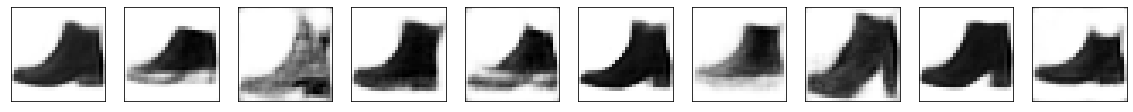

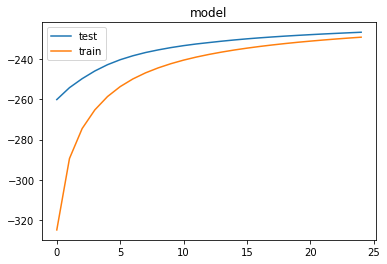

In [0]:
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [5, 10, 50, 100, 500, 1000, 2000, 3000, 4500, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

x_train_0, y_train_0, x_test_0, y_test_0, train_dataset_0, test_dataset_0 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0])
x_train_1, y_train_1, x_test_1, y_test_1, train_dataset_1, test_dataset_1 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[1])
x_train_2, y_train_2, x_test_2, y_test_2, train_dataset_2, test_dataset_2 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[2])
x_train_3, y_train_3, x_test_3, y_test_3, train_dataset_3, test_dataset_3 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[3])
x_train_4, y_train_4, x_test_4, y_test_4, train_dataset_4, test_dataset_4 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[4])
x_train_5, y_train_5, x_test_5, y_test_5, train_dataset_5, test_dataset_5 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[5])
x_train_6, y_train_6, x_test_6, y_test_6, train_dataset_6, test_dataset_6 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[6])
x_train_7, y_train_7, x_test_7, y_test_7, train_dataset_7, test_dataset_7 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[7])
x_train_8, y_train_8, x_test_8, y_test_8, train_dataset_8, test_dataset_8 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[8])
x_train_9, y_train_9, x_test_9, y_test_9, train_dataset_9, test_dataset_9 = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[9])

z_size = 25
model_0 = CVAE(z_size)
model_1 = CVAE(z_size)
model_2 = CVAE(z_size)
model_3 = CVAE(z_size)
model_4 = CVAE(z_size)
model_5 = CVAE(z_size)
model_6 = CVAE(z_size)
model_7 = CVAE(z_size)
model_8 = CVAE(z_size)
model_9 = CVAE(z_size)

model_dict = {'0' : model_0,
              '1' : model_1,
		          '2' : model_2,
              '3' : model_3,
              '4' : model_4,
              '5' : model_5,
              '6' : model_6,
              '7' : model_7,
              '8' : model_8,
              '9' : model_9,}

train_test_dataset(model_0, train_dataset_0, test_dataset_0, 50, generate=True)
train_test_dataset(model_1, train_dataset_1, test_dataset_1, 40, generate=True)
train_test_dataset(model_2, train_dataset_2, test_dataset_2, 30, generate=True)
train_test_dataset(model_3, train_dataset_3, test_dataset_3, 25, generate=True)
train_test_dataset(model_4, train_dataset_4, test_dataset_4, 25, generate=True)
train_test_dataset(model_5, train_dataset_5, test_dataset_5, 25, generate=True)
train_test_dataset(model_6, train_dataset_6, test_dataset_6, 25, generate=True)
train_test_dataset(model_7, train_dataset_7, test_dataset_7, 25, generate=True)
train_test_dataset(model_8, train_dataset_8, test_dataset_8, 25, generate=True)
train_test_dataset(model_9, train_dataset_9, test_dataset_9, 25, generate=True)

#### Reconstruct images

Original Pictures:


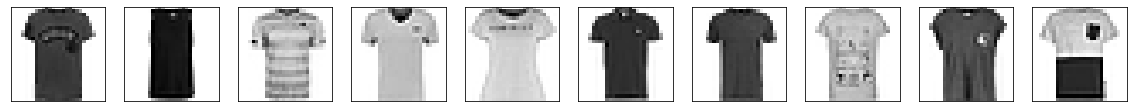

Reconstructed Pictures, with ELBO loss:


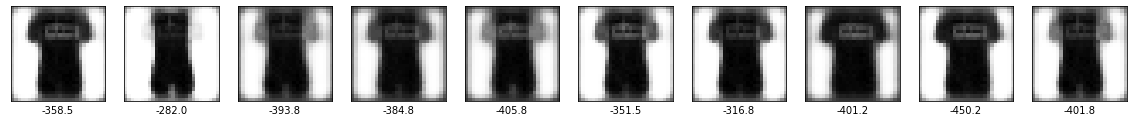

In [0]:
def reconstruct_images(model, images):
    images_n = len(images)
    x = images/input_range
    #x[x >= 0.5] = 1.0
    #x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(x)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i],_,_ = calculate_ELBO(model,x[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model_0, x_test_0[0:10])

#### Visualize the latent space

In [0]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    
    z_mean, z_logvar = model.encode(pic_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    
    if any(z_logvar[:,i]>5 for i in range(z_size)):
      outliers +=1
      continue
      
    if data_y[i] == 0:
      color = 'blue'
    if data_y[i] == 1:
      color = 'orange'
    if data_y[i] == 2:
      color = 'green'
    if data_y[i] == 3:
      color = 'red'
    if data_y[i] == 4:
      color = 'purple'  
    if data_y[i] == 5:
      color = 'brown'
    if data_y[i] == 6:
      color = 'pink'
    if data_y[i] == 7:
      color = 'gray'
    if data_y[i] == 8:
      color = 'black'
    if data_y[i] == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
    #plt.xlim([-1000,1000])
    #plt.ylim([-1000,1000])
    #plt.annotate('{}'.format(i),(z[:,a],z[:,b]))
  print('{} Outliers detected'.format(outliers))


visualize_latent_space(model_8, 0,800, x_test_8, y_test_8, 0,1)

#labels = []; 
#for i in range(N_train): labels.append(i)
#plot_images(x_train, labels, [250,300])

#### Check reconstruction performance for untrained classes and create table of losses


Model trained with class 0


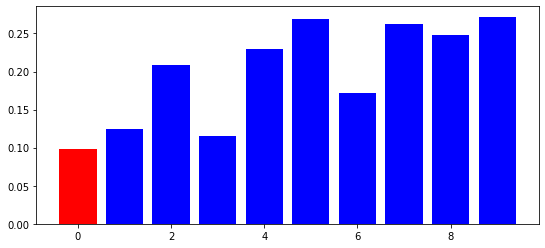

Model trained with class 1


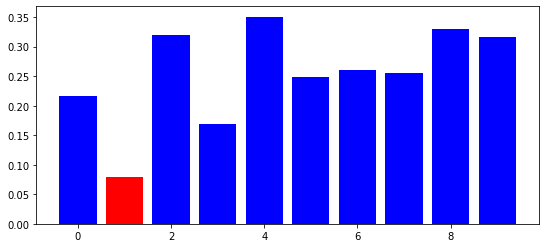

Model trained with class 2


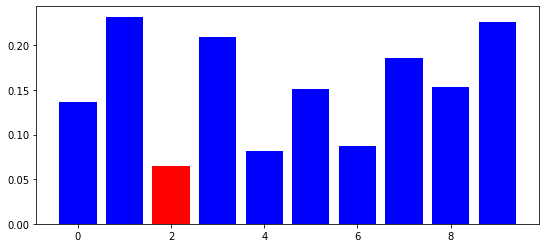

Model trained with class 3


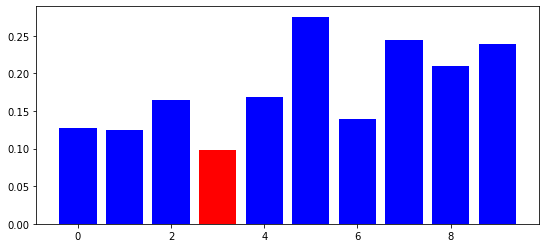

Model trained with class 4


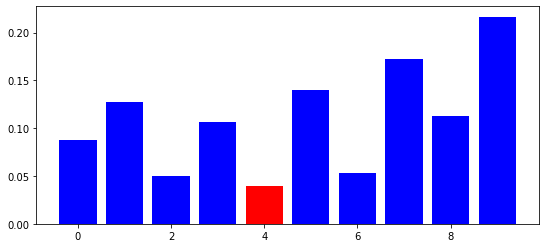

Model trained with class 5


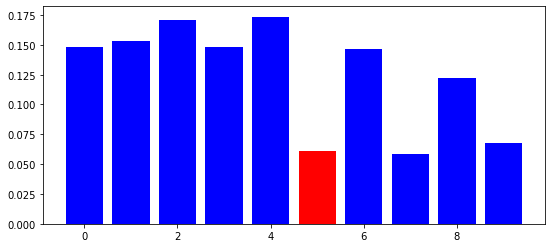

Model trained with class 6


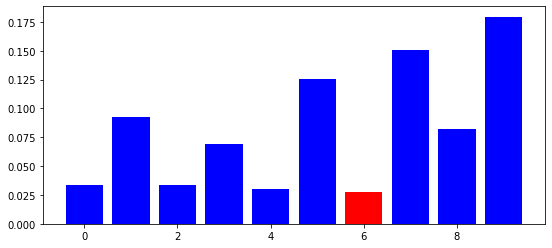

Model trained with class 7


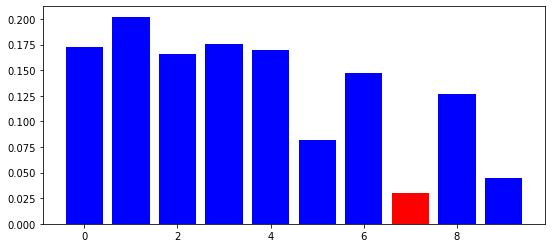

Model trained with class 8


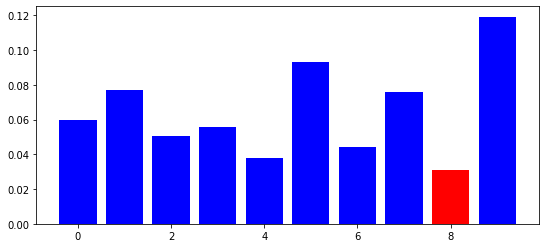

Model trained with class 9


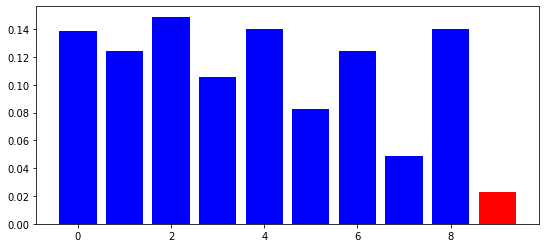

,Model 0,Model 1,Model 2,Model 3,Model 4,Model 5,Model 6,Model 7,Model 8,Model 9
Class 0,2.91,6.42,4.04,3.77,2.60,4.38,1.00,5.09,1.77,4.09
Class 1,1.62,1.03,3.01,1.62,1.66,1.99,1.20,2.62,1.00,1.61
Class 2,6.22,9.56,1.94,4.93,1.50,5.11,1.00,4.94,1.51,4.45
Class 3,2.06,3.03,3.74,1.75,1.90,2.66,1.23,3.15,1.00,1.89
Class 4,7.55,11.56,2.67,5.56,1.30,5.72,1.00,5.59,1.25,4.62
Class 5,4.39,4.04,2.47,4.49,2.28,1.00,2.04,1.33,1.52,1.34
Class 6,6.13,9.32,3.11,5.01,1.90,5.23,1.00,5.26,1.58,4.44
Class 7,8.87,8.65,6.26,8.25,5.82,1.98,5.09,1.00,2.56,1.65
Class 8,8.05,10.66,4.96,6.78,3.67,3.96,2.65,4.09,1.00,4.54
Class 9,11.79,13.70,9.82,10.40,9.39,2.94,7.78,1.95,5.17,1.00


In [0]:
table_of_losses = np.zeros([N_class, N_class])
for i in range(0,N_class):
  model = model_dict[str(i)]
  print('Model trained with class {}'.format(i))
  plt.figure(figsize=[9,4])
  for j in range(N_class):
    test_images = x_test[(y_test==j)]
    test_images = set_pixels_binary(test_images)
    test_images = test_images.reshape(len(test_images), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    #_,loss,_ = calculate_ELBO(model,test_images)
    #loss = -calculate_pixel_squared(model,test_images)
    loss = calculate_ssim(model, test_images)
    table_of_losses[j,i] = loss
    if j==i:
      color='red'
    else:
      color='blue'
    plt.bar(j,loss.numpy(),color=color)
    #print('ELBO loss for class {}: {}'.format(i,loss))
  plt.show()

for i in range(N_class):
    table_of_losses[i,:] = table_of_losses[i,:]/np.min(table_of_losses[i,:])
 
index = list(str('-') * N_class)
columns = list(str('-') * (N_class))
for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = 'Model ' + str(i)

table_loss = pd.DataFrame.from_records(np.around(table_of_losses, decimals=2), index=index, columns=columns)
table_loss


#### Classify test images

In [0]:
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test_classes, y_test_classes = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

predicted_class = np.zeros([1,len(x_test_classes)])
predicted_probabilities = np.zeros([len(x_test_classes),10])
for i in range(len(x_test_classes)):
  if not i%10:
    clear_output()
    print('Progress:{}%'.format(100*(i+1)/len(x_test_classes)))
  test_image = x_test_classes[i]/input_range
  test_image = test_image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
  
  loss_per_model = np.empty([1,10])
  a = np.empty([1,10])
  for j in range(0,10):
    model = model_dict[str(j)]
    loss1,_,_ = calculate_ELBO(model,test_image)
    loss_per_model[0,j]= -loss1
  a[0,:] = loss_per_model[0,:]/np.min(loss_per_model[0,:])
  a = np.multiply(a,-2)
  e_x = np.exp(a)
  predicted_probabilities[i,:] = (e_x[0,:] / e_x[0,:].sum())*100
  max_index = np.argmax(predicted_probabilities[i,:])
  predicted_class[0,i] = max_index%10
print(predicted_class)

Progress:99.91%
[[6. 6. 6. ... 9. 9. 9.]]


### Calculate losses for each VAE

In [0]:
def compute_losses(x):
  losses_per_image = np.zeros([len(x),10])
  for i in range(len(x)):
    if not i%10:
      clear_output()
      print('Progress:{}%'.format(100*(i+1)/len(x)))
    image = x[i]/input_range
    image = image.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    for j in range(0,10):
      model = model_dict[str(j)]
      loss,_,_ = calculate_ELBO(model,image)
      losses_per_image[i,j]= loss
  return losses_per_image

In [0]:
losses_per_image_test = compute_losses(x_test_classes)
losses_per_image_train = compute_losses(x_train)

### Find classes

In [0]:
def losses_softmax(x):
  x_normalized = np.zeros(np.shape(x))
  softmax_probabilities = np.zeros(np.shape(x))
  for i in range(len(x)):
    x_normalized[i,:] = x[i,:]/np.min(x[i,:])
    x_normalized[i,:] = np.multiply(x_normalized[i,:],-2)
    e_x = np.exp(x_normalized)
    softmax_probabilities[i,:] = (np.exp(x_normalized[i,:]) / np.exp(x_normalized[i,:]).sum())*100
  return softmax_probabilities

In [0]:
softmax_probabilities_test = losses_softmax(losses_per_image_test)
softmax_probabilities_train = losses_softmax(losses_per_image_train)

In [0]:
def classify_highest_softmax(x):
  predicted_class = np.zeros([len(x)],)
  for i in range(len(x)):
    predicted_class[i] = np.argmax(x[i,:])
  return predicted_class

In [0]:
predicted_class_1 = classify_highest_softmax(softmax_probabilities_test)

#### Create ROC curves and find optimal thresholds

In [0]:
def ROC_thresholds(y, prob_x, plot_ROC_curves=1):
  y_true = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_true[y[i].astype('int'),i]=1 #each row has all the images, each row is a class. Values are 1 where the image corresponds to that class

  y_score = np.zeros([10,len(y)])
  for i in range(len(y)):
    y_score[:,i] = prob_x[i] #each column is the softmax distribution for each image

  
  optimal_thresholds = np.zeros([10,])
  for i in range(10):
    fpr, tpr, threshold = roc_curve(y_true[i,:], y_score[i,:])
    optimal_idx = np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))
    optimal_threshold = threshold[optimal_idx]
    optimal_thresholds[i] = optimal_threshold
    if plot_ROC_curves == 1:
      plot = plt.figure()
      plt.plot(fpr, tpr, color='red')
      plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC curve for class '+str(i))
      plt.show()
  return optimal_thresholds

In [0]:
optimal_thresholds = ROC_thresholds(y_test, softmax_probabilities_test, 0)

In [0]:
def classify_ROC_thresholds(prob_x, thresholds, y):
  predicted_class = np.zeros([len(y),])
  for i in range(len(y)):
    diff = prob_x[i,:]-thresholds
    predicted_class[i]=np.argmax(diff)
  return predicted_class

In [0]:
predicted_class_2 = classify_ROC_thresholds(softmax_probabilities_test, optimal_thresholds, y_test)

#### Check accuracy and plot misslabeled images

In [0]:
def compute_accuracy(predictions, y):
  predictions = predictions.astype('int')
  y = y.astype('int')

  wrong_guesses = []
  table_of_counts = np.zeros([N_class+1, N_class+1])
  for i in range(len(predictions)):
    table_of_counts[y[i], predictions[i]]+=1
    if y[i] != predictions[i]:
        wrong_guesses.append(i)
  
  for i in range(N_class):
    accuracy_of_class = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])
    table_of_counts[i,-1] = accuracy_of_class.astype('float16')
  for i in range(N_class):
    table_of_counts[-1,i] = np.sum(table_of_counts[0:10,i])-table_of_counts[i,i]

  index = list(str('-') * (N_class+1))
  columns = list(str('-') * (N_class+1))
  for i in range(N_class):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
  index[-1] = 'False Positives'
  columns[-1] = 'Percentage'
  table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

  accuracy = 100*table_of_counts.trace()/np.sum(table_of_counts[0:10,0:10])
  average_accuracy = np.sum(table['Percentage'])/10

  return table, accuracy, average_accuracy, wrong_guesses

In [0]:
table_1, accuracy_1, average_accuracy_1, wrong_guesses_1 = compute_accuracy(predicted_class_1, y_test)
table_2, accuracy_2, average_accuracy_2, wrong_guesses_2 = compute_accuracy(predicted_class_2, y_test)

In [0]:
# Convolutional VAE for each class results in accuracy of 98.16% with z_size = 10
# Convolutional VAE for each class results in accuracy of 89.90% with z_size = 2

In [0]:
import pandas as pd
table_same = pd.read_csv('/content/drive/My Drive/4YP/table_same.csv')
table_increase = pd.read_csv('/content/drive/My Drive/4YP/table_increase.csv')
table_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_decrease.csv')
table_loss_same = pd.read_csv('/content/drive/My Drive/4YP/table_loss_same.csv')
table_loss_increase = pd.read_csv('/content/drive/My Drive/4YP/table_loss_increase.csv')
table_loss_decrease = pd.read_csv('/content/drive/My Drive/4YP/table_loss_decrease.csv')
predicted_prob_same = np.load('/content/drive/My Drive/4YP/predicted_prob_same.npy')
predicted_prob_increase = np.load('/content/drive/My Drive/4YP/predicted_prob_increase.npy')
predicted_prob_decrease = np.load('/content/drive/My Drive/4YP/predicted_prob_decrease.npy')
losses_per_image_test = np.load('/content/drive/My Drive/4YP/losses_per_image_test.npy')
losses_per_image_train = np.load('/content/drive/My Drive/4YP/losses_per_image_train.npy')

### Classifier

In [0]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
losses_per_image_test = np.load('/content/drive/My Drive/4YP/losses_per_image_test.npy')
losses_per_image_train = np.load('/content/drive/My Drive/4YP/losses_per_image_train.npy')
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
chosen_classes=[0,1,2,3,4,5,6,7,8,9]
chosen_numbers = [5, 10, 50, 100, 500, 1000, 2000, 3000, 4500, 6000]
x_train, y_train = change_ratio(x_train, y_train, chosen_classes, chosen_numbers)
chosen_numbers = [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
x_test, y_test = change_ratio(x_test, y_test, chosen_classes, chosen_numbers)

y_train = y_train[..., tf.newaxis]
y_test = y_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((losses_per_image_train, y_train)).shuffle(len(y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((losses_per_image_test, y_test)).shuffle(len(y_test)).batch(32)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [119]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

#def loss_object(labels, predictions):
#  loss = 0
#  for i in range(len(labels)):
#    if labels[i] != np.argmax(predictions[i]):
#      loss +=1
#  return loss

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

EPOCHS = 5

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)
  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print(template.format(epoch+1, train_loss.result(), train_accuracy.result()*100, test_loss.result(), test_accuracy.result()*100))

  # Reset the metrics for the next epoch
  train_loss.reset_states(); train_accuracy.reset_states(); test_loss.reset_states(); test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 13.300100326538086, Accuracy: 17.47742462158203, Test Loss: 14.508848190307617, Test Accuracy: 10.0
Epoch 2, Loss: 13.300084114074707, Accuracy: 17.47742462158203, Test Loss: 14.505626678466797, Test Accuracy: 10.0
Epoch 3, Loss: 13.300086975097656, Accuracy: 17.47742462158203, Test Loss: 14.50723648071289, Test Accuracy: 10.0
Epoch 4, Loss: 13.295967102050781, Accuracy: 17.47742462158203, Test Loss: 14.505620956420898, Test Accuracy: 10.0
Epoch 5, Loss: 13.302830696105957, Accuracy: 17.4

In [67]:
import keras.backend as K
#y = tf.placeholder("int64", [None, 10], name = "y")

class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = Dense(128, activation= tf.nn.relu)
    self.d2 = Dense(128, activation= tf.nn.relu)
    self.d3 = Dense(10, activation = tf.nn.relu)

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = tf.nn.softmax(x)
    #tf.nn.sparse_softmax_cross_entropy_with_logits(labels, x)
    return x

#def custom_loss():
#    def myloss(y_true,y_pred):
#        return tf.keras.losses.SparseCategoricalCrossentropy()
#    return myloss

model = MyModel()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(losses_per_image_train, y_train, epochs=5)

model.evaluate(losses_per_image_test, y_test, verbose=2)

ValueError: ignored

In [63]:
results = np.argmax(model(losses_per_image_test), axis=1)
table, _, average_accuracy, _ = compute_accuracy(results, y_test)
print(average_accuracy)
table


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

46.623828125


,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,0.0,0.0,0.0,25.0,0.0,0.0,904.0,0.0,71.0,0.0,0.000000
Class 1,0.0,146.0,0.0,622.0,0.0,0.0,217.0,0.0,14.0,1.0,14.601562
Class 2,0.0,0.0,0.0,6.0,10.0,0.0,855.0,0.0,129.0,0.0,0.000000
Class 3,0.0,0.0,0.0,477.0,5.0,0.0,436.0,0.0,82.0,0.0,47.687500
Class 4,0.0,0.0,0.0,38.0,57.0,0.0,743.0,0.0,162.0,0.0,5.699219
Class 5,0.0,2.0,0.0,0.0,0.0,347.0,0.0,311.0,11.0,329.0,34.687500
Class 6,0.0,0.0,0.0,19.0,4.0,0.0,832.0,0.0,145.0,0.0,83.187500
Class 7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,836.0,0.0,163.0,83.625000
Class 8,0.0,0.0,0.0,0.0,0.0,0.0,11.0,3.0,986.0,0.0,98.625000
Class 9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,2.0,981.0,98.125000


In [73]:
a = [[1, 2.5 , 5 ], [0 , 4 , 1 ]]

tf.nn.softmax(a)

<tf.Tensor: id=139352, shape=(2, 3), dtype=float32, numpy=
array([[0.01664452, 0.07459555, 0.9087599 ],
       [0.01714783, 0.93623954, 0.04661262]], dtype=float32)>